<a href="https://colab.research.google.com/github/Daivar/Deep_Learning_Models/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

7 365


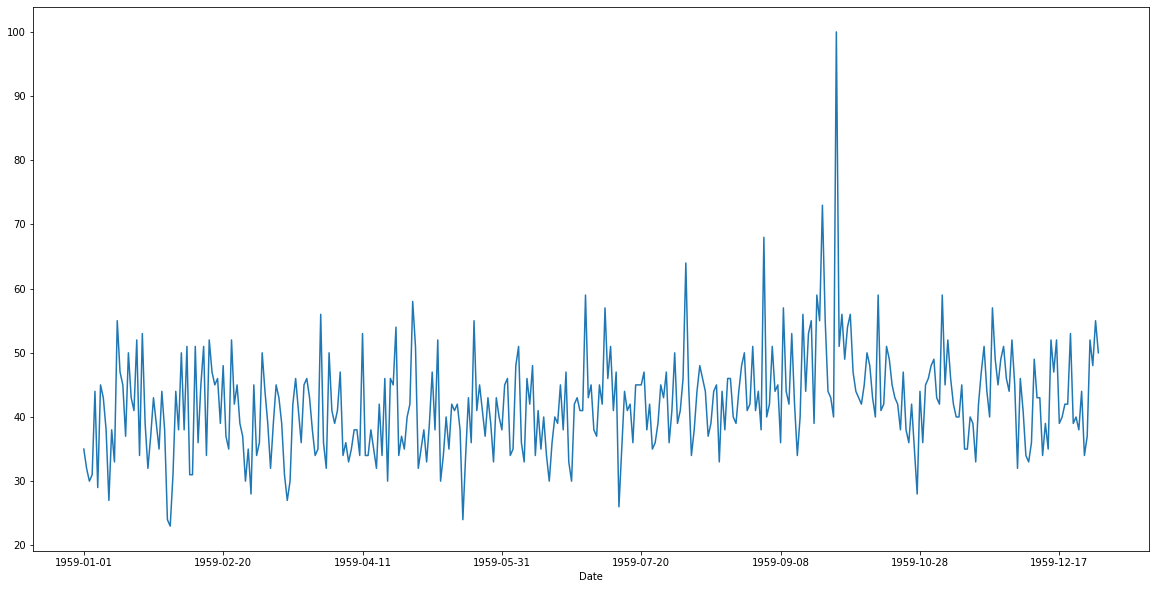

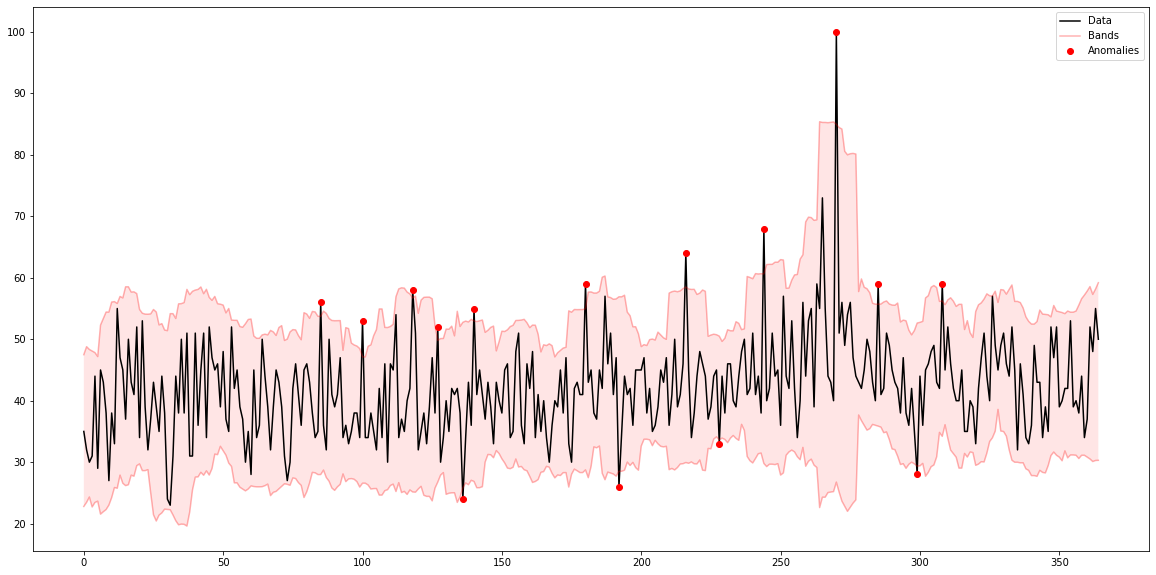

In [1]:
# Deviation bands

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

femb = 'https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/09_Sequential_Data_Analysis/daily-total-female-births.csv'
data = pd.read_csv(femb ,index_col=['Date'])
data['Births'][270] = 100
column = data['Births']
column.plot(figsize=(20,10))

N = len(column)
time = np.arange(0,N)
# (len(data),len(time))

#parameters
window_percentage = 2 # Change this to 5, 15
k = int(len(column) * (window_percentage/100))
print(k,N)

column = column.to_numpy()

std_tollerace = 2 # +/-std_tollerace std devs (good values are 3 and 3.5)
get_bands = lambda data : (np.mean(data) + std_tollerace * np.std(data), np.mean(data) - std_tollerace * np.std(data)) 
#get_bands = lambda data : (np.mean(data) + np.nanquantile(data,0.99),np.mean(data) - np.nanquantile(data,0.99)) # use this for 99% percentile

# why there are if statements in providing indexes to range selector. It is there to handle boundary cases and avoid negative indexes and greater than size of whole data list
# change this - skip this logic 
bands = [get_bands(column[range(
    (0 if i-k < 0 else i-k),
    (i+k if i+k < N else N)
  )]) for i in range(0,N)]

# One way to understand what the previous line does it to change it
# bands = [get_bands(column[range(i)]) for i in range(0,N)]

upper, lower = zip(*bands)

# compute local outliers 
anomalies = (column > upper) | (column < lower)


# plotting...
plt.figure(figsize=(20,10))
plt.plot(time,column,'k',label='Data')
plt.plot(time,upper,'r-',label='Bands',alpha=0.3)
plt.plot(time,lower,'r-',alpha=0.3)

plt.plot(time[anomalies],column[anomalies],'ro',label='Anomalies')
plt.fill_between(time, upper, lower, facecolor='red',alpha=0.1)
plt.legend()

plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = 'https://raw.githubusercontent.com/MindaugasBernatavicius/DeepLearningCourse/master/09_Sequential_Data_Analysis/catfish.csv'
catfish_sales = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True, date_parser=(lambda x: datetime.strptime(x, '%Y-%m-%d')))
# sarimax needs infered frequenty
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

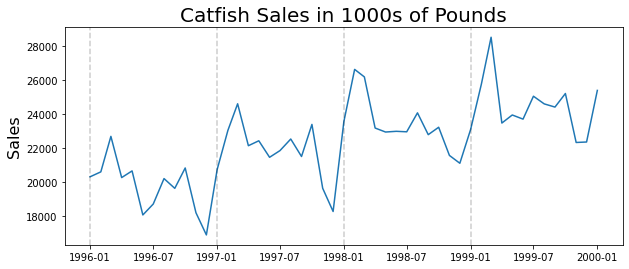

In [4]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [5]:
# test / train data split
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

order = (0,1,0)
seasonal_order = (1,0,1,12)

print(test_data) # 6 values

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64


In [6]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)] # 5 values predicted
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Text(0, 0.5, 'Error')

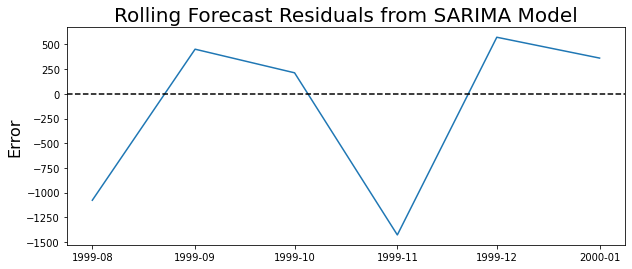

In [7]:
rolling_residuals = test_data - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

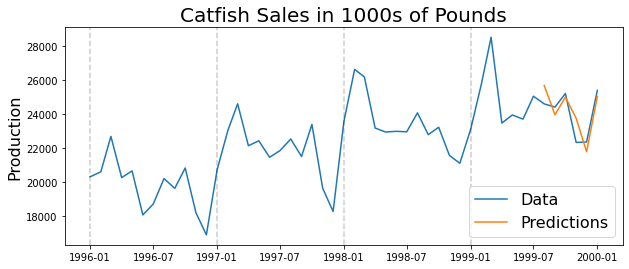

In [8]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [9]:
#At December 1 1998
lim_catfish_sales[datetime(1998,12,1)] = 10000

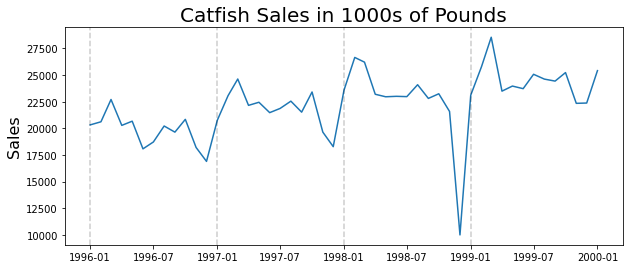

In [10]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [11]:
# Removing trend

first_diff = lim_catfish_sales.diff()[1:]

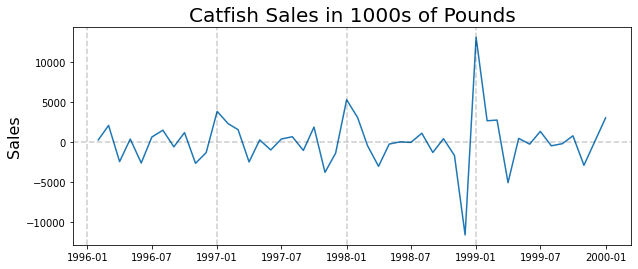

In [12]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [14]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Text(0, 0.5, 'Error')

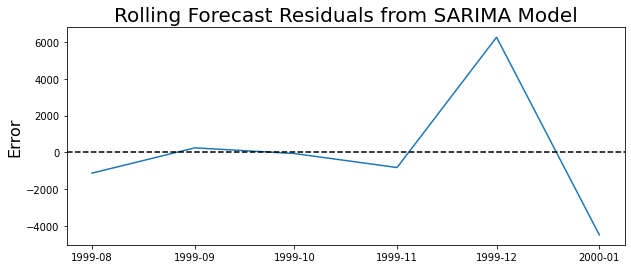

In [16]:
rolling_residuals = test_data - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

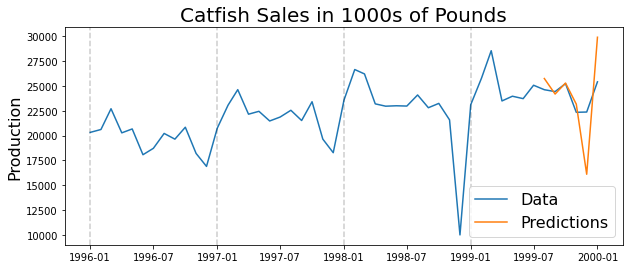

In [17]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.092


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3199.0401425010805


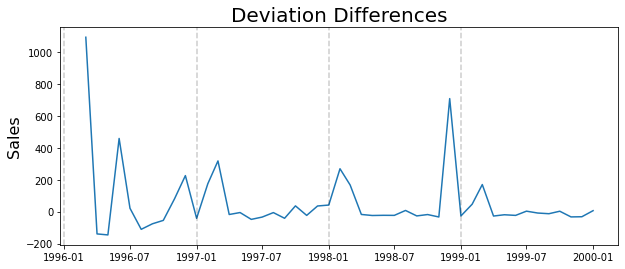

In [20]:
# detecting anomaly

rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

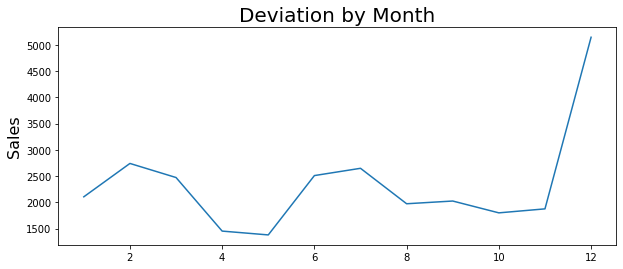

In [22]:
# Detecting the anomaly: Seasonal Method

month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [23]:
# skai2iuojant nuokrypius

december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [24]:
min_dev = np.inf 

# we iterate through the collection of all months
# ... with one of the month removed in each loop
# ... and calculate the standard deviation between 
# ... all those months. If the new deviation is bigger
# ... that the deviations before we remember the deviation
# ... and the month that caused it. The month that caused it
# ... will be our anomaly.

# In summary: which datapoint was not in the set 
# ... when we were calculating the standard deviation!
anom = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        anom = date

anom

Timestamp('1998-12-01 00:00:00')

NameError: ignored

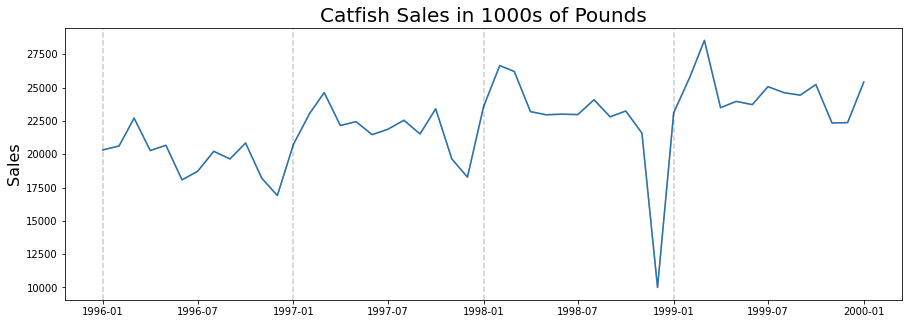

In [32]:

plt.figure(figsize=(15,5))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Text(0, 0.5, 'Error')

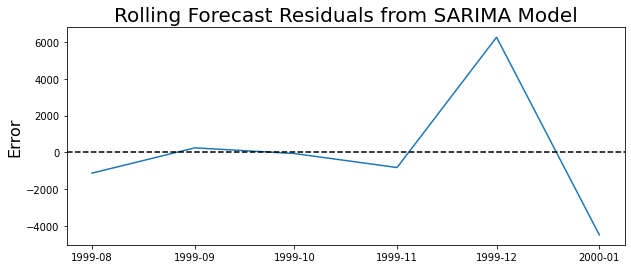

In [30]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

rolling_residuals = test_data - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

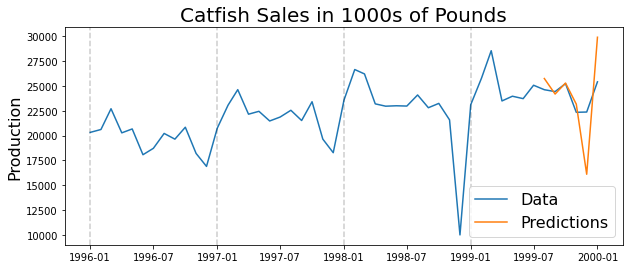

In [31]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [36]:
# this is from git, so it takes a long time, at some point (in 2021) it would be good to check if the default version in google colab has the necessary features 
!pip3 install git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-de9ls0xy
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-de9ls0xy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: Package 'statsmodels' requires a different Python: 3.7.12 not in '>=3.8'


In [ ]:
stl = STL(ice_cream_interest)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,7))

plt.subplot(4,1,1)
plt.plot(ice_cream_interest)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

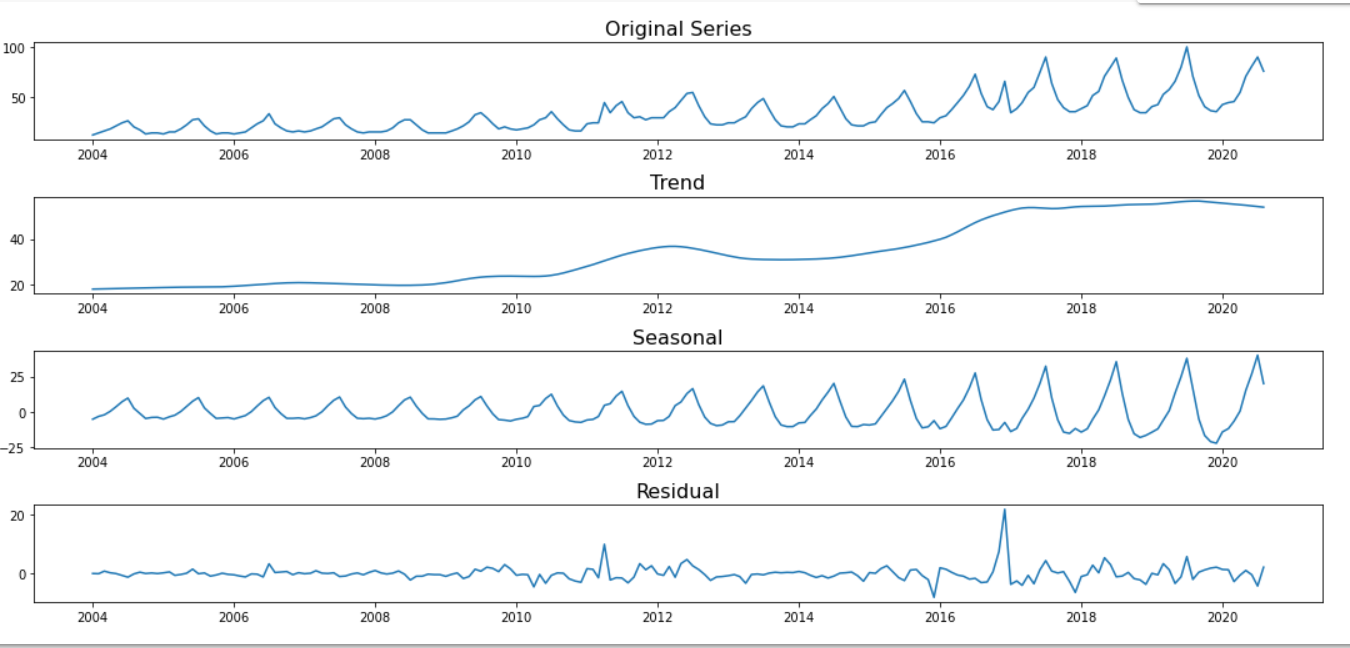

In [43]:
# Luminol - Linkedln sukurta biblioteka Time Series analizei

!pip3 install luminol

In [44]:
from luminol.anomaly_detector import AnomalyDetector
from luminol.correlator import Correlator
import time

# ts = 'data.csv'  # or
ts = { 
    '1490323038': 3,
    '1490323048': 4,
    '1490323058': 6,
    '1490323068': 100,
    '1490323078': 152,
    '1490323088': 6,
    '1490323098': 5,
}

my_detector = AnomalyDetector(ts, score_threshold=0.9) # score_threshold=1.5 is needed to obtain anomalies
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()
anom_score = []

for (timestamp, value) in score.iteritems():
    # t_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp))
    # anom_score.append([t_str, value])
    anom_score.append([timestamp, value])

for score in anom_score:
    print(score)

for a in anomalies:
    time_period = a.get_time_window()
    print(a)


print(dir(anomalies[0])) # [ .... '__subclasshook__', '__weakref__', 'anomaly_score', 'end_timestamp', 'exact_timestamp', 'get_time_window', 'start_timestamp']
print(len(anomalies))

print("The anomally lasted from: " + str(anomalies[0].start_timestamp) + " to: " + str(anomalies[0].end_timestamp))

[1490323038, 0.0]
[1490323048, 0.014159937040436232]
[1490323058, 0.039647823713221446]
[1490323068, 2.075982657988527]
[1490323078, 1.8265185987199508]
[1490323088, 1.3319208979626855]
[1490323098, 0.7093516228784498]
Anomaly from 1490323068 to 1490323088 with score 2.075982657988527
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'anomaly_score', 'end_timestamp', 'exact_timestamp', 'get_time_window', 'start_timestamp']
1
The anomally lasted from: 1490323068 to: 1490323088
